In [1]:
import numpy as np
from bk_functions import *
from scipy import integrate
import matplotlib.pyplot as plt
from utils import *

(6825, 3)


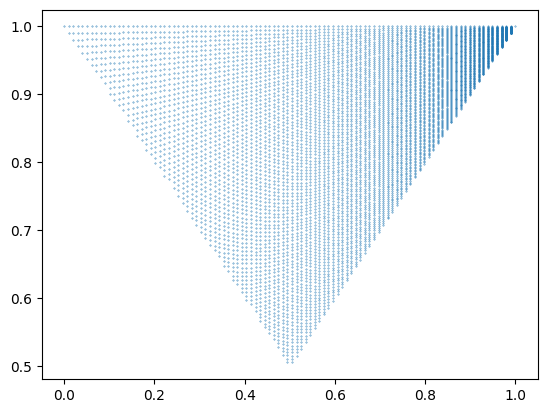

In [8]:
k_vals, bk = create_bk_dataset(grid_points=100, func_name='bk_eq', func_arg=None, kmin=0.0001,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=1)
k_vals = k_vals.numpy()
bk = bk.numpy()
# bk = bk*bk # TEST FOR INNER PRODUCT
print(k_vals.shape)

plt.scatter(k_vals[:,0], k_vals[:,1], s=0.1)

(2500, 3)


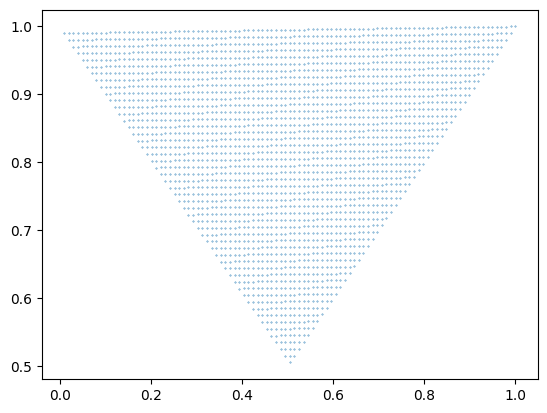

In [7]:
k_vals, bk = create_bk_dataset(grid_points=100, func_name='bk_eq', func_arg=None, kmin=0.0001,\
                               kmax=1.0, n_points_k2=None, scale_invariant=True, k2_sample_version=0)
k_vals = k_vals.numpy()
bk = bk.numpy()
# bk = bk*bk # TEST FOR INNER PRODUCT
print(k_vals.shape)

plt.scatter(k_vals[:,0], k_vals[:,1], s=0.1)

In [76]:
def Delta_fNL_scale_w_interp_TEST(k_vals, bk_result_1, bk_result_2, kmin, scale_invariant=True, DEBUG=False):
    """
    KZ note: I try to make the integration as defensive as possible for nans. But the interpolater can still give nan. 
            see:https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator
            note the irregular of shapes of the interpolation boundaries
            For now I'll just force these points to 0.
            
            In the future maybe consider extrapolation with interpn, but I don't fill safe with that.
            
    Compute integral using interpolation of grid data
    from bk_result_1 and bk_result_2. This would give:
    <bk_result_1-bk_result_2 | bk_result_1 - bk_result_2> / <bk_result_2 | bk_result_2>
    """
    if not scale_invariant:
        raise NotImplementedError

    k1_grid = k_vals[:,0]
    k2_grid = k_vals[:,1]
    k3_grid = k_vals[:,2]
    
    assert np.all(k3_grid == 1), "k3 is not all 1. ?"
    assert bk_result_1.shape[0] == bk_result_2.shape[0], "the two sets of Bk should be evaluated at the same ks"

    # Create interpolation function
    interp_func_1 = interpolate.CloughTocher2DInterpolator(
        list(zip(k1_grid, k2_grid)), bk_result_1
    )

    interp_func_2 = interpolate.CloughTocher2DInterpolator(
        list(zip(k1_grid, k2_grid)), bk_result_2
    )
    
    def integrand_diff(x, y):
        # Square the interpolated function value
        return (interp_func_1(x, y) - interp_func_2(x, y))**2

    def integrand_2(x, y):
        # Square the interpolated function value
        result = (interp_func_2(x, y))**2
        if DEBUG:
            if np.isnan(result):
                print(f"NaN encountered in integrand at x={x:.6f}, y={y:.6f}")
        return result
    
    def integrand_diff_safe(x, y):
        if y >= x and y+x>1. and y <= 1.0 and x > kmin and x < 1.0:  # Only evaluate within the valid region
            result = integrand_diff(x, y)
        else:
            result = 0.0  # Return 0 for points outside our region of interest
        if DEBUG:
            if np.isnan(result):
                print(f"NaN encountered in integrand at x={x:.6f}, y={y:.6f}")
        # KZ note: this is not ideal
        if np.isnan(result):
            result = 0.
        return result
    
    def integrand_2_safe(x, y):
        if y >= x and y+x>1. and y <= 1.0 and x > kmin and x < 1.0:  # Only evaluate within the valid region
            result = integrand_2(x, y)
        else:
            result = 0.0  # Return 0 for points outside our region of interest
        if DEBUG:
            if np.isnan(result):
                print(f"NaN encountered in integrand at x={x:.6f}, y={y:.6f}")
        # KZ note: this is not ideal
        if np.isnan(result):
            result = 0.
        return result
    
    # Inner product of 1 and 2
    IP_1_2, error_1 = integrate.dblquad(
        integrand_diff_safe,
        kmin+1e-6, 
        1.,  # x limits
        lambda x: 0., # note the for stablitiy the limit on y is handeled in integra_XX_safe
        lambda x: 1.
    )

    IP_1_1, error_2 = integrate.dblquad(
        integrand_2_safe,
        kmin+1e-6, 
        1.,  # x limits
        lambda x: 0., # note the for stablitiy the limit on y is handeled in integra_XX_safe
        lambda x: 1.
    )
    
    # KZ TESTING START
    if DEBUG:
        test_x = np.linspace(kmin, 1.0, 100)
        test_y = np.linspace(0, 1.0, 100)
        for x in test_x:
            for y in test_y:
                if y >= 1.0-x and y <= 1.0 and y>x:  # Only test points in your integration region
                    val = integrand_2(x, y)
                    if np.isnan(val):
                        print(f"Found NaN at x={x}, y={y}")
    # KZ TESTING END
    
    Delta_fNL = IP_1_2 / IP_1_1
    print('true <B|B> is', IP_1_1)
    print('The bias estimation of fNL is Delta_fNL = ', Delta_fNL)

    return Delta_fNL

In [77]:
""" KZ note:
    for bk_eq, Mathematica gives: 0.1098022005. Pretty similar to this. and seems kmin = 0.01 is fine in this case. 
    A equilateral should peak at <1,1,1> anyways
"""

Delta_fNL_scale_w_interp_TEST(k_vals, bk, bk, kmin=k_vals.min(), DEBUG=False)


true <B|B> is 0.10980377155539547
The bias estimation of fNL is Delta_fNL =  0.0


0.0

In [78]:
# other tests: add 0.1 to every point at bk gives bias = 0.022?? is this too small? But if not than the training seems to be completely ok
# maybe not impossible because mse should be of this order, and the integration over S^2 should be similar

Delta_fNL_scale_w_interp_TEST(k_vals, bk+0.1, bk, kmin=k_vals.min(), DEBUG=False)

true <B|B> is 0.10980377155539547
The bias estimation of fNL is Delta_fNL =  0.022767362941900855


0.022767362941900855

# below is test

In [16]:
def plot_3d_data(xy_vals, bk, method='scatter', title='3D Plot'):
    """
    Plot 3D data with color mapping
    
    Args:
        k_vals: array of shape (N, 2) containing x and y coordinates
        bk: array of shape (N,) containing z values
        method: 'scatter' or 'surface'
        title: plot title
    """
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection='3d')
    
    # Set viewing angle
    ax.azim = -75
    ax.dist = 10
    ax.elev = 30
    
    x = xy_vals[:, 0]
    y = xy_vals[:, 1]
    z = bk.flatten()
    
    if method == 'scatter':
        # Create scatter plot with color mapping
        scatter = ax.scatter3D(x, y, z, 
                             c=z,  # Color by z value
                             cmap='viridis',  # Choose colormap
                             s=30,  # Marker size
                             alpha=0.6)  # Transparency
        
        # Add colorbar
        fig.colorbar(scatter, ax=ax, label='Z Value')
        
    elif method == 'surface':
        # Create triangulation surface plot
        surf = ax.plot_trisurf(x, y, z,
                             cmap='viridis',
                             alpha=0.8)
        
        # Add colorbar
        fig.colorbar(surf, ax=ax, label='Z Value')
    
    # Labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    
    # Set axis limits if needed
    # ax.set_xlim([x.min(), x.max()])
    # ax.set_ylim([y.min(), y.max()])
    # ax.set_zlim([z.min(), z.max()])
    
    plt.show()

/tmp/ipykernel_420080/485922144.py:16: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10


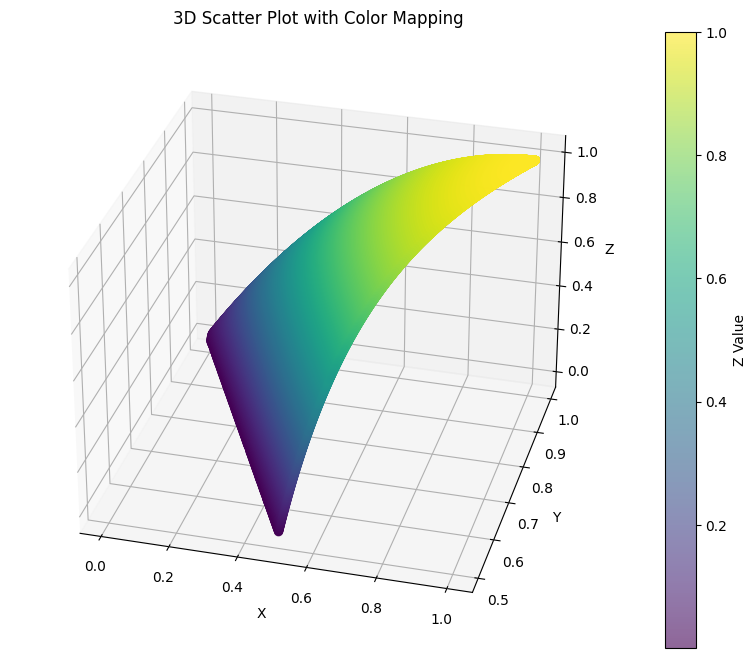

In [17]:

# Generate sample data
n_points = k_vals.shape[0]
x = k_vals[:,0]
y = k_vals[:,1]
z = bk.flatten()

xy_vals = np.column_stack((x, y))

# Create both types of plots
plot_3d_data(xy_vals, z, method='scatter', title='3D Scatter Plot with Color Mapping')


k1_grid range: 0.01 1.0
k2_grid range: 0.50054055 1.0
[0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92 0.91 0.9  0.89 0.88 0.87 0.86
 0.85 0.84 0.83 0.82 0.81 0.8  0.79 0.78 0.77 0.76 0.75 0.74 0.73 0.72
 0.71 0.7  0.69 0.68 0.67 0.66 0.65 0.64 0.63 0.62 0.61 0.6  0.59 0.58
 0.57 0.56 0.55 0.54 0.53 0.52 0.51 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.  ] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


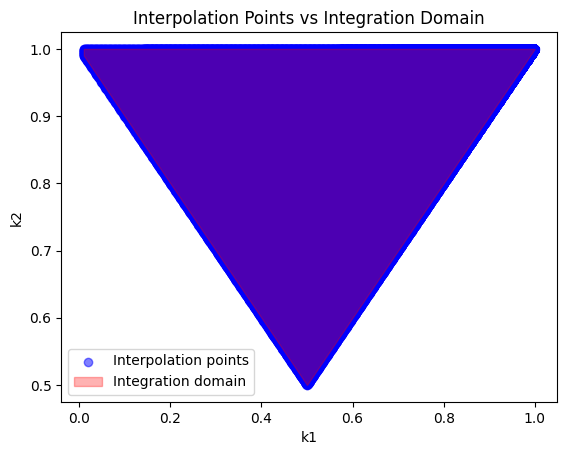

In [28]:
k1_grid = k_vals[:,0]
k2_grid = k_vals[:,1]
kmin = k_vals.min()

# Check interpolation domain coverage
print("k1_grid range:", np.min(k1_grid), np.max(k1_grid))
print("k2_grid range:", np.min(k2_grid), np.max(k2_grid))

# Plot interpolation points and integration domain
plt.scatter(k1_grid, k2_grid, c='blue', alpha=0.5, label='Interpolation points')

# Plot integration domain
x = np.linspace(kmin, 1, 100)
y_min = np.maximum(x, 1-x)
y_max = np.ones_like(x)
# print(y_min, y_max)
plt.fill_between(x, y_min, y_max, alpha=0.3, color='red', label='Integration domain')

plt.legend()
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Interpolation Points vs Integration Domain')
plt.show()

In [55]:


interp_func_2 = interpolate.CloughTocher2DInterpolator(
        list(zip(k1_grid, k2_grid)), bk)

In [62]:
# KZ note: this still is nan, has to do with interpolator

testx=0.361336
testy=0.638669
print(testx+testy)
interp_func_2(testx, testy)

1.000005


array([nan])

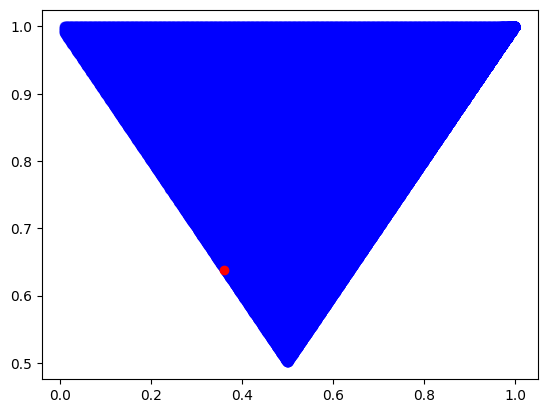

In [64]:
# Plot interpolation points and integration domain
plt.scatter(k1_grid, k2_grid, c='blue', alpha=0.5, label='Interpolation points')

plt.scatter(testx, testy, c='red')